In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


In [2]:
%load_ext autoreload
%autoreload 2

# This tutorial explains the basic pipline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup
* Here we load a simple experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [3]:
import agentnet.experiments.boolean_reasoning as experiment
print experiment.__doc__


This is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1~3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 = ( X1 and not X2) or (X2 and not X1)
 - Y2 = not Y1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +0.1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -0.1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will converge to a strategy of polling X for as long as they yiel

In [4]:
#Create an environment with all default parameters
env = experiment.BooleanReasoningEnvironment()

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, a single one-step RNN
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import RecurrentMemoryLayer
from agentnet.agent import Agent

In [6]:
import lasagne

#64 hidden neurons
n_hid=64


observation_size = (None,)+tuple(env.observation_size)

observation_layer = lasagne.layers.InputLayer(observation_size,name="obs_input")
prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")

#memory
#note that this isn't the same as lasagne recurrent units (see next text tab for detail)
rnn = RecurrentMemoryLayer(prev_state_layer,
                           observation_layer,
                           name="rnn0")

#q_eval
q_eval = lasagne.layers.DenseLayer(rnn,
                                   num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")

#resolver
epsilon = theano.shared(np.float32(0.1),name="e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(observation_layer,
              {rnn:prev_state_layer},
              q_eval,resolver)


In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[rnn0.hid_to_hid.W,
 rnn0.hid_to_hid.b,
 rnn0.input0_to_hid.W,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* Such sessions are represented as tensors with dimensions matching pattern [batch_session_i, time_tick, ...]
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [8]:
#produce interaction sequences of length <= 10
state_seq,observation_seq,agent_state,action_seq,qvalues_seq = agent.get_sessions(
    env,
    session_length=10,
    batch_size=env.batch_size,
)


hidden_seq = agent_state[rnn]

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


# Evaluating loss function
* In this case, we want to 
 * first get pairs of (predicted Qvalue, reference Qvalue) for all actions commited
 * second, define loss function
 * third, compute grad and update weights

#### Define loss functions

In [9]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning


#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(1),name = 'q_learning_gamma')


squarred_Qerror = qlearning.get_elementwise_objective(
    qvalues_seq,
    action_seq,
    rewards_seq,
    is_alive_seq,
    gamma_or_gammas=gamma,)


mse_Qloss = squarred_Qerror.sum(axis = 1).mean()

In [10]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-3

In [11]:
loss = mse_Qloss + reg_l2

#### Compute weight updates

In [12]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.1)

#### Some auxilary evaluation metrics

In [13]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [14]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_Qloss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [15]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   action_names=env.feature_names,
                  
                  plot_policy = with_plots)

session # 0
 X2(qv = 0.843986034393) -> -0.10000000149 |  X2(qv = 0.607254743576) -> -0.5 | 



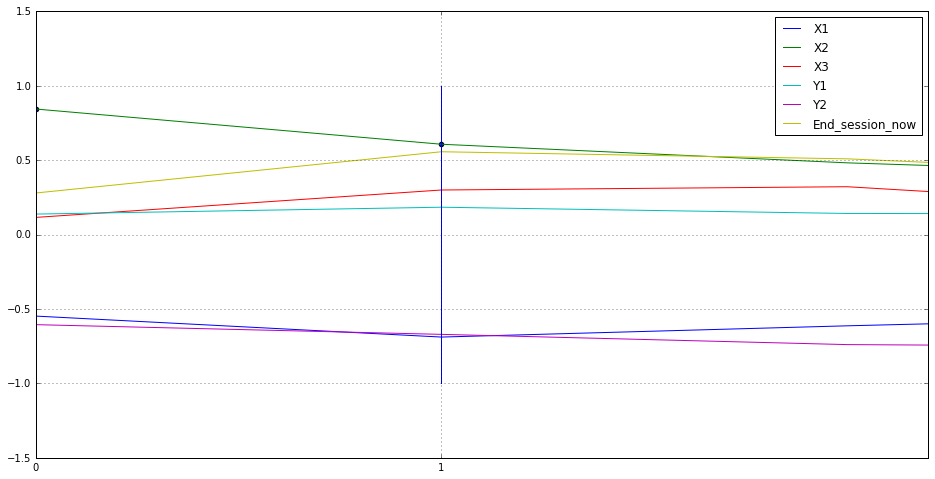

In [16]:
#visualize untrained network performance (which is mostly random)
env.generate_new_data_batch(1)
display_sessions(with_plots=True)

# Training loop

In [17]:
from agentnet.display import Metrics
score_log = Metrics()

In [18]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 100,loss 7.56152, epsilon 0.96275, rewards: ( e-greedy -0.09100, greedy 0.00200) 
rec 7.472 reg 0.089
epoch 200,loss 9.17123, epsilon 0.92696, rewards: ( e-greedy -0.15490, greedy 0.00180) 
rec 9.082 reg 0.089
epoch 300,loss 1.73173, epsilon 0.89257, rewards: ( e-greedy -0.17241, greedy 0.00162) 
rec 1.643 reg 0.088
epoch 400,loss 7.86170, epsilon 0.85954, rewards: ( e-greedy -0.17217, greedy 0.02746) 
rec 7.774 reg 0.088
epoch 500,loss 7.06773, epsilon 0.82779, rewards: ( e-greedy -0.16995, greedy 0.02671) 
rec 6.980 reg 0.087
epoch 600,loss 4.76305, epsilon 0.79730, rewards: ( e-greedy -0.14196, greedy -0.00196) 
rec 4.676 reg 0.087
epoch 700,loss 6.76808, epsilon 0.76799, rewards: ( e-greedy -0.24176, greedy 0.06424) 
rec 6.682 reg 0.087
epoch 800,loss 8.03223, epsilon 0.73984, rewards: ( e-greedy -0.20359, greedy 0.05981) 
rec 7.946 reg 0.086
epoch 900,loss 7.81660, epsilon 0.71279, rewards: ( e-greedy -0.26323, greedy 0.02383) 
rec 7.731 reg 0.086
epoch 1000,loss 8.57835, ep

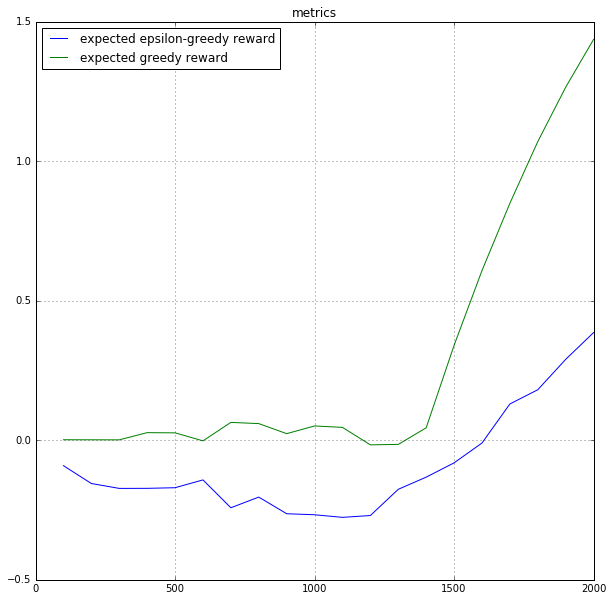

Random session examples
session # 0
 X1(qv = 1.55748593807) -> -0.10000000149 |  X2(qv = 0.743044674397) -> 0.10000000149 | 



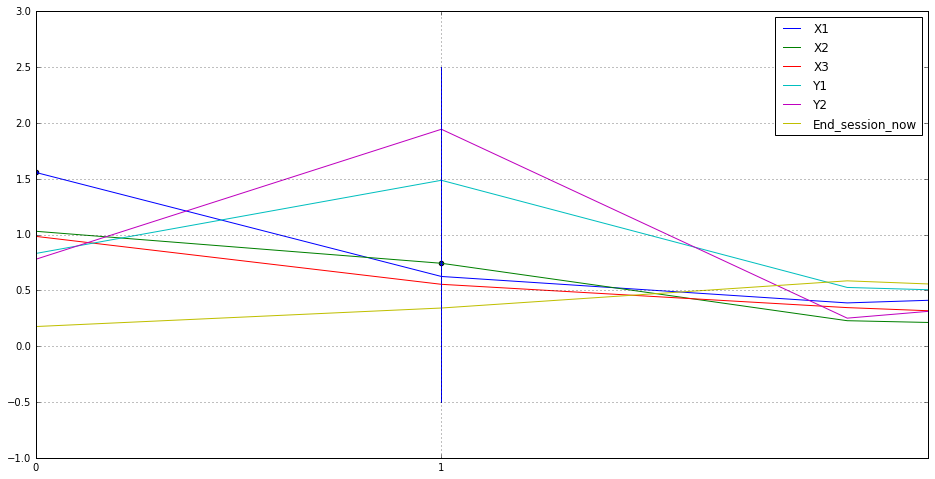

session # 1
 X1(qv = 1.55748593807) -> 0.10000000149 |  X2(qv = 0.670752704144) -> 0.10000000149 | 



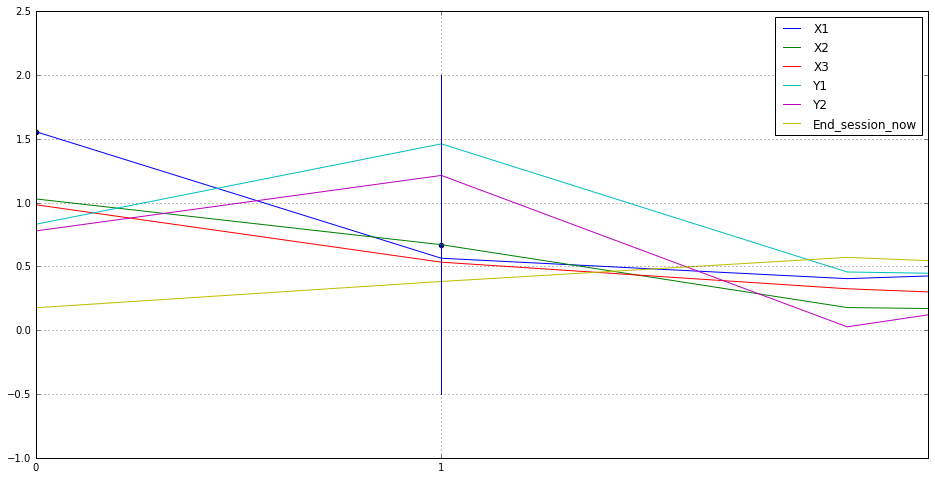

session # 2
 X3(qv = 0.98440092802) -> -0.10000000149 |  X2(qv = 0.603114485741) -> -0.10000000149 |  Y2(qv = 0.848562479019) -> 3.0 | 



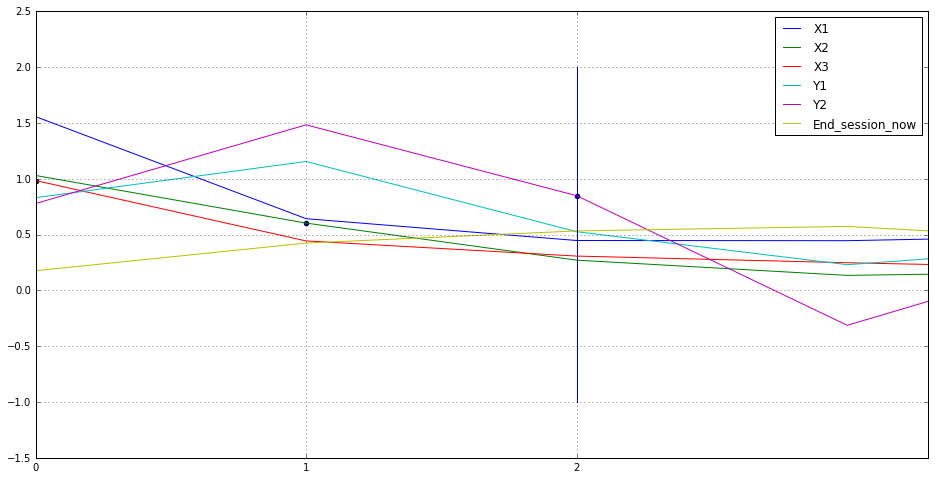

epoch 2100,loss 6.45362, epsilon 0.46012, rewards: ( e-greedy 0.48245, greedy 1.59321) 
rec 6.354 reg 0.099
epoch 2200,loss 6.69606, epsilon 0.44404, rewards: ( e-greedy 0.59821, greedy 1.73389) 
rec 6.595 reg 0.101
epoch 2300,loss 5.26904, epsilon 0.42859, rewards: ( e-greedy 0.58739, greedy 1.85850) 
rec 5.166 reg 0.103
epoch 2400,loss 10.85298, epsilon 0.41375, rewards: ( e-greedy 0.54565, greedy 1.97265) 
rec 10.747 reg 0.106
epoch 2500,loss 4.72743, epsilon 0.39949, rewards: ( e-greedy 0.54208, greedy 2.07739) 
rec 4.620 reg 0.107
epoch 2600,loss 9.70218, epsilon 0.38578, rewards: ( e-greedy 0.53387, greedy 2.16765) 
rec 9.594 reg 0.108
epoch 2700,loss 3.33177, epsilon 0.37262, rewards: ( e-greedy 0.62349, greedy 2.24688) 
rec 3.221 reg 0.111
epoch 2800,loss 3.06383, epsilon 0.35997, rewards: ( e-greedy 0.75714, greedy 2.32419) 
rec 2.952 reg 0.111
epoch 2900,loss 4.75373, epsilon 0.34781, rewards: ( e-greedy 0.86942, greedy 2.39578) 
rec 4.640 reg 0.113
epoch 3000,loss 5.70586, e

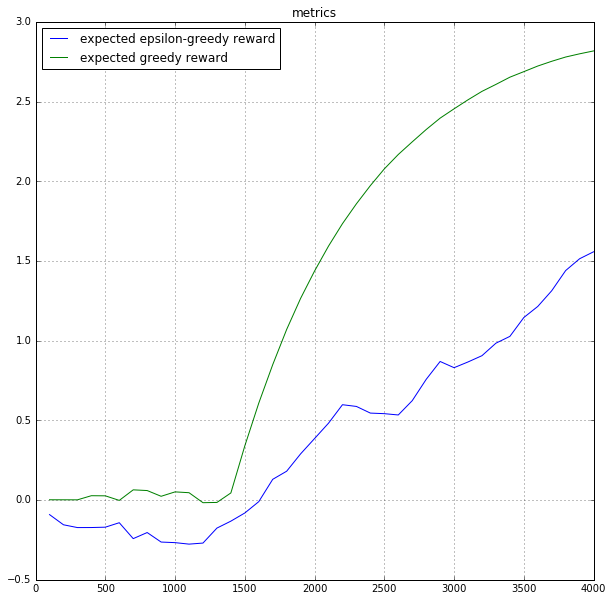

Random session examples
session # 0
 X1(qv = 2.67664718628) -> -0.10000000149 |  Y2(qv = 2.76754808426) -> 3.0 | 



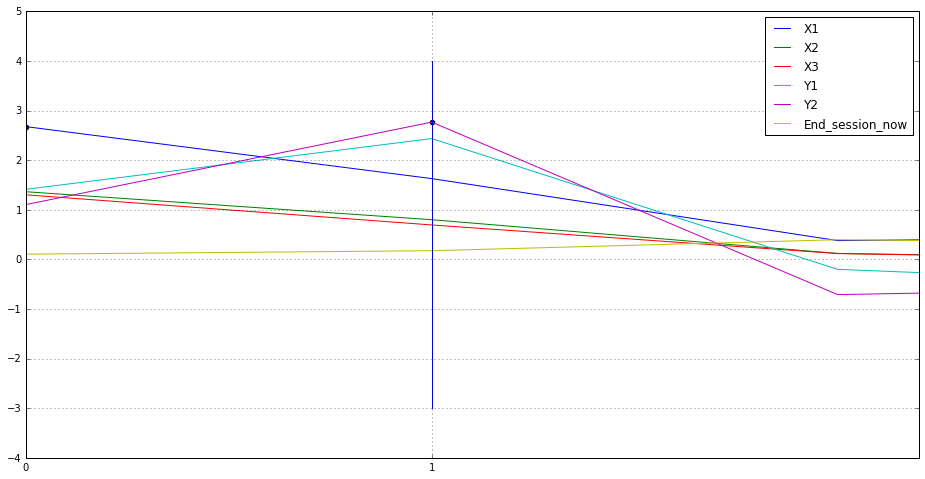

session # 1
 X1(qv = 2.67664718628) -> 0.10000000149 |  Y1(qv = 2.79198217392) -> 3.0 | 



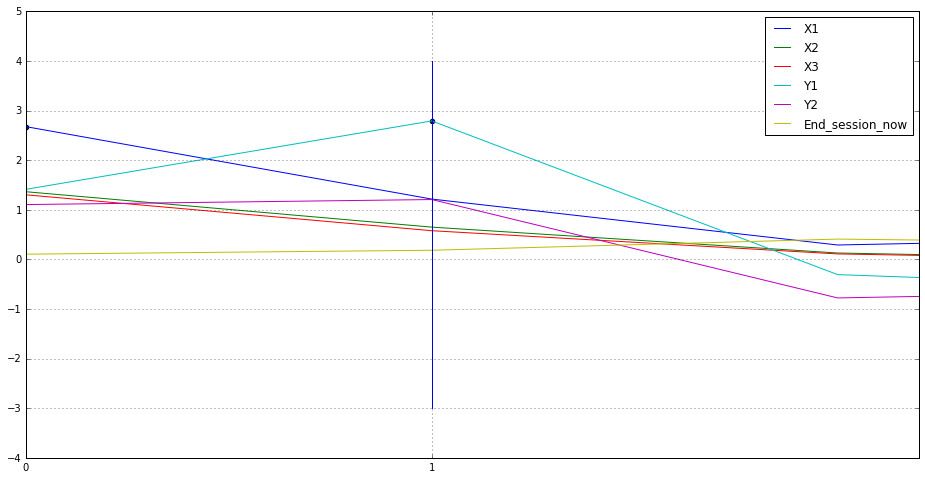

session # 2
 X1(qv = 2.67664718628) -> -0.10000000149 |  Y2(qv = 2.76754784584) -> 3.0 | 



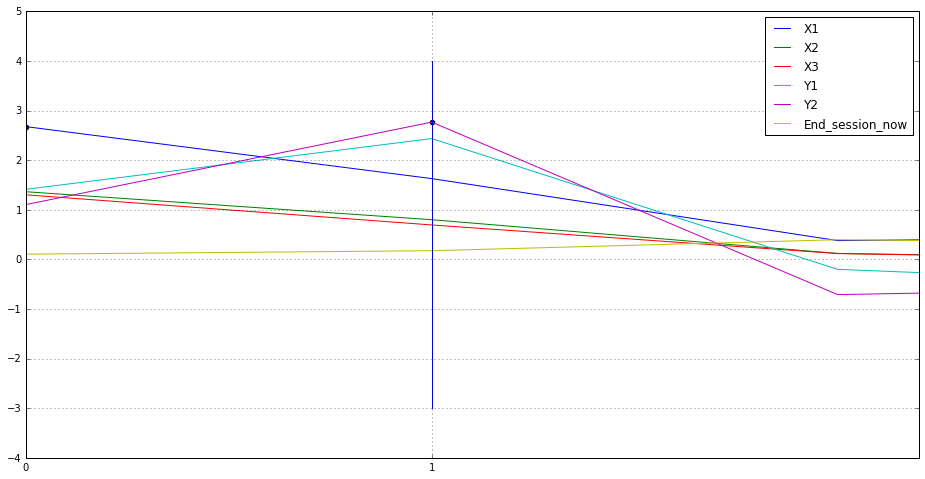

epoch 4100,loss 2.16312, epsilon 0.23428, rewards: ( e-greedy 1.61671, greedy 2.83755) 
rec 2.031 reg 0.132
epoch 4200,loss 2.35440, epsilon 0.22706, rewards: ( e-greedy 1.70804, greedy 2.84780) 
rec 2.220 reg 0.134
epoch 4300,loss 4.24472, epsilon 0.22011, rewards: ( e-greedy 1.64324, greedy 2.78802) 
rec 4.110 reg 0.135
epoch 4400,loss 1.33083, epsilon 0.21344, rewards: ( e-greedy 1.75191, greedy 2.80721) 
rec 1.195 reg 0.136
epoch 4500,loss 1.34565, epsilon 0.20703, rewards: ( e-greedy 1.82172, greedy 2.82649) 
rec 1.209 reg 0.137
epoch 4600,loss 2.76875, epsilon 0.20088, rewards: ( e-greedy 1.85855, greedy 2.84384) 
rec 2.631 reg 0.138
epoch 4700,loss 3.64380, epsilon 0.19496, rewards: ( e-greedy 1.87370, greedy 2.84946) 
rec 3.506 reg 0.138
epoch 4800,loss 4.60937, epsilon 0.18928, rewards: ( e-greedy 1.84433, greedy 2.86251) 
rec 4.470 reg 0.139
epoch 4900,loss 2.22032, epsilon 0.18382, rewards: ( e-greedy 1.88089, greedy 2.87426) 
rec 2.080 reg 0.140
epoch 5000,loss 2.34090, eps

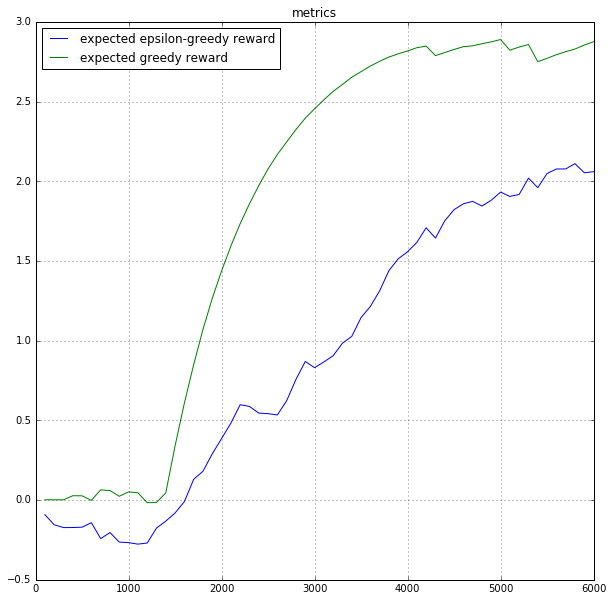

Random session examples
session # 0
 X1(qv = 2.8577246666) -> -0.10000000149 |  Y2(qv = 2.97368454933) -> 3.0 | 



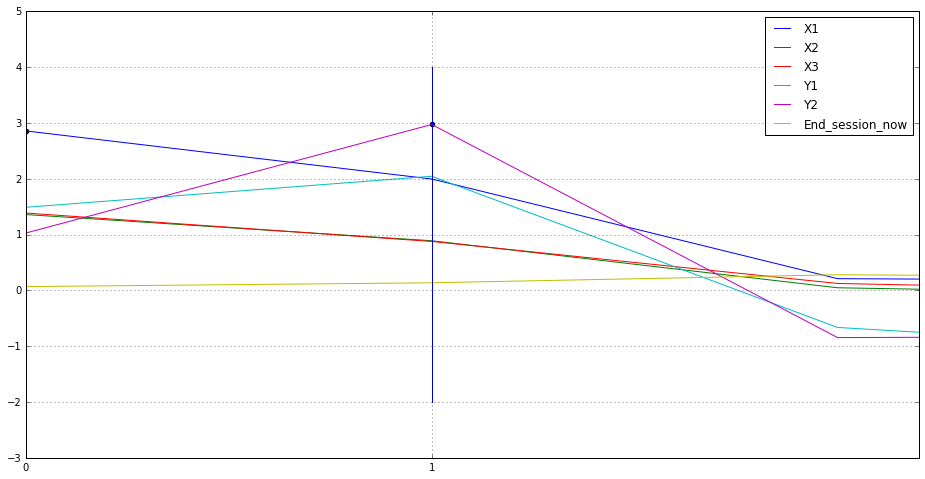

session # 1
 X1(qv = 2.8577246666) -> 0.10000000149 |  Y1(qv = 2.91130852699) -> 3.0 | 



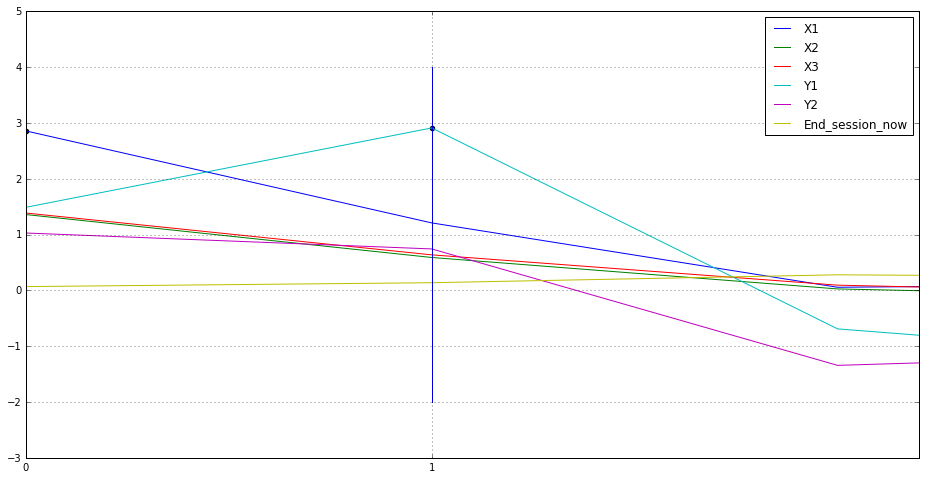

session # 2
 X2(qv = 1.35905122757) -> 0.10000000149 |  Y1(qv = 1.08139944077) -> -3.0 |  X1(qv = 0.594659745693) -> -0.10000000149 |  X1(qv = 0.499763548374) -> -0.5 |  Y2(qv = 0.948842167854) -> 3.0 | 



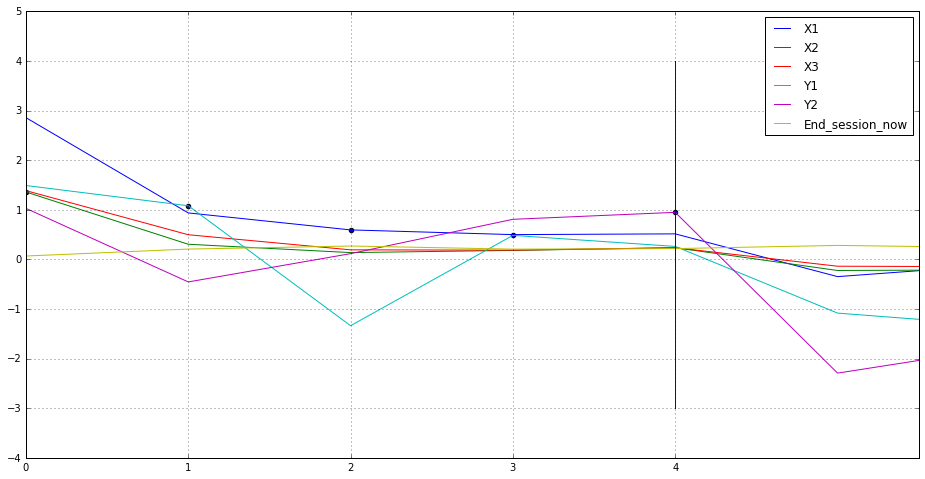

epoch 6100,loss 1.74131, epsilon 0.13280, rewards: ( e-greedy 2.05197, greedy 2.88933) 
rec 1.592 reg 0.149
epoch 6200,loss 0.83655, epsilon 0.12956, rewards: ( e-greedy 2.07177, greedy 2.82539) 
rec 0.687 reg 0.149
epoch 6300,loss 2.28032, epsilon 0.12644, rewards: ( e-greedy 2.09359, greedy 2.84085) 
rec 2.130 reg 0.150
epoch 6400,loss 0.23538, epsilon 0.12344, rewards: ( e-greedy 2.17223, greedy 2.85477) 
rec 0.085 reg 0.150
epoch 6500,loss 2.47547, epsilon 0.12056, rewards: ( e-greedy 2.18401, greedy 2.86929) 
rec 2.325 reg 0.151
epoch 6600,loss 0.20848, epsilon 0.11779, rewards: ( e-greedy 2.25461, greedy 2.87636) 
rec 0.057 reg 0.151
epoch 6700,loss 2.63597, epsilon 0.11513, rewards: ( e-greedy 2.30115, greedy 2.89073) 
rec 2.484 reg 0.152
epoch 6800,loss 1.09125, epsilon 0.11258, rewards: ( e-greedy 2.36203, greedy 2.89765) 
rec 0.939 reg 0.153
epoch 6900,loss 0.62140, epsilon 0.11013, rewards: ( e-greedy 2.39683, greedy 2.90989) 
rec 0.468 reg 0.153
epoch 7000,loss 1.70901, eps

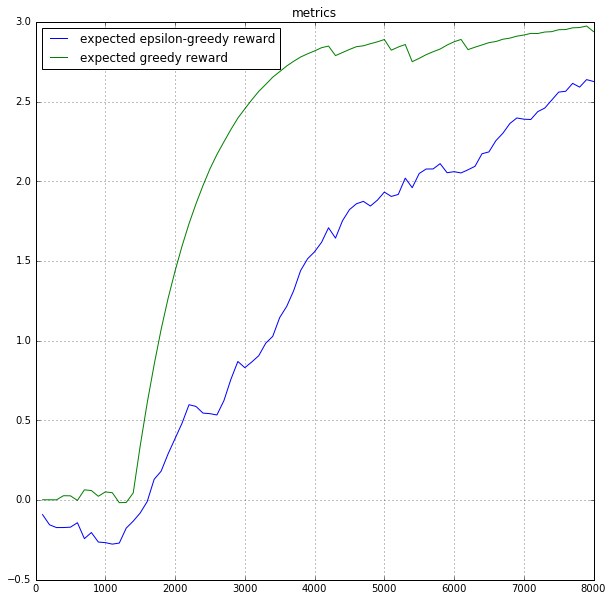

Random session examples
session # 0
 Y1(qv = 1.50055789948) -> -3.0 |  Y2(qv = 2.51226305962) -> 3.0 | 



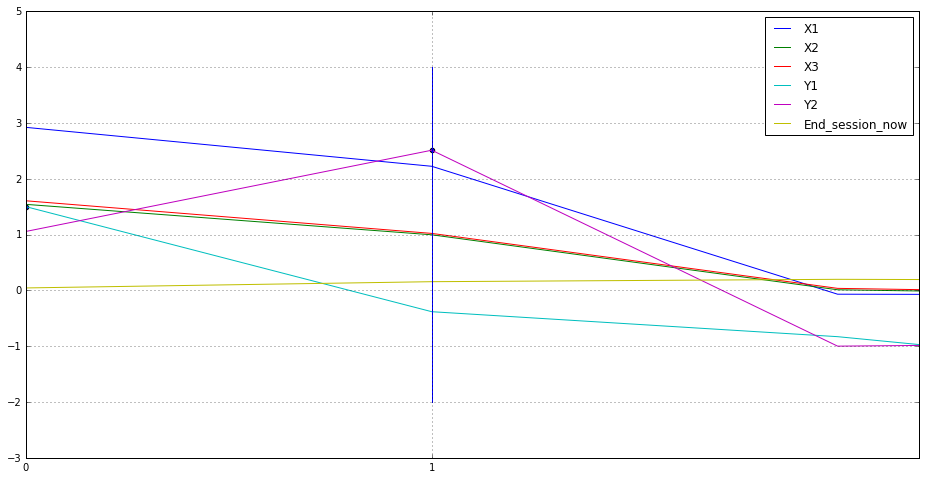

session # 1
 X1(qv = 2.92177176476) -> -0.10000000149 |  Y2(qv = 3.04257774353) -> 3.0 |  X1(qv = 0.213887006044) -> -0.5 |  X1(qv = 0.151856124401) -> -0.5 |  Y2(qv = 0.375186890364) -> -0.5 | 



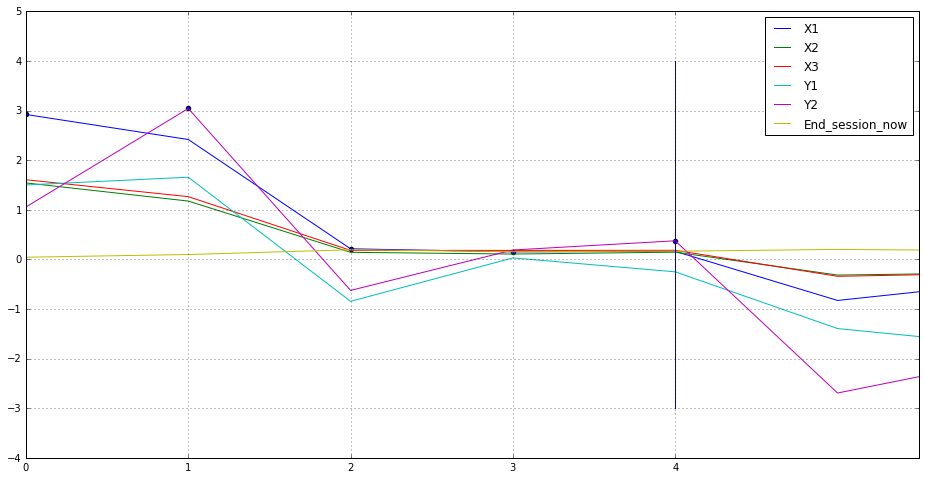

session # 2
 X1(qv = 2.92177176476) -> -0.10000000149 |  Y2(qv = 3.04257774353) -> 3.0 |  X1(qv = 0.213886842132) -> -0.5 |  Y2(qv = 0.189787641168) -> -0.5 | 



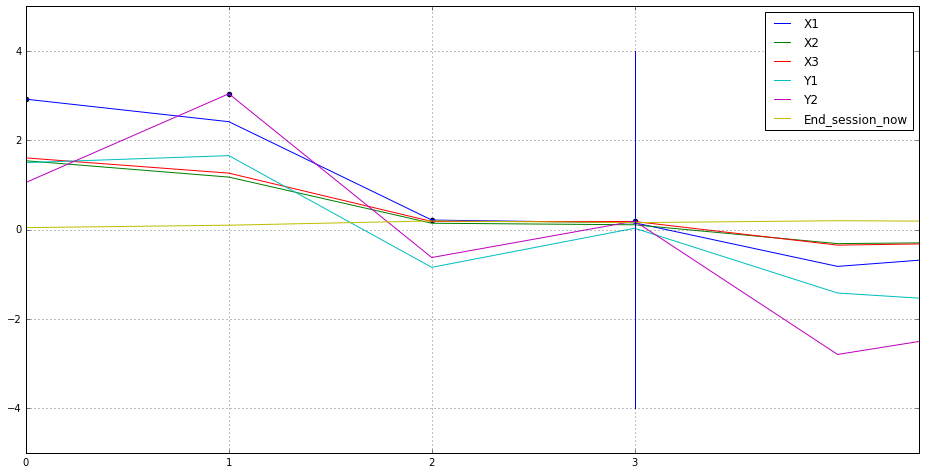

epoch 8100,loss 2.40232, epsilon 0.08721, rewards: ( e-greedy 2.62604, greedy 2.94643) 
rec 2.245 reg 0.157
epoch 8200,loss 0.17577, epsilon 0.08575, rewards: ( e-greedy 2.66244, greedy 2.94979) 
rec 0.019 reg 0.157
epoch 8300,loss 0.60040, epsilon 0.08435, rewards: ( e-greedy 2.63520, greedy 2.95281) 
rec 0.443 reg 0.158
epoch 8400,loss 0.16771, epsilon 0.08300, rewards: ( e-greedy 2.66568, greedy 2.95153) 
rec 0.010 reg 0.158
epoch 8500,loss 0.16350, epsilon 0.08170, rewards: ( e-greedy 2.70111, greedy 2.95838) 
rec 0.006 reg 0.158
epoch 8600,loss 0.16752, epsilon 0.08046, rewards: ( e-greedy 2.72900, greedy 2.96054) 
rec 0.010 reg 0.158
epoch 8700,loss 0.46453, epsilon 0.07927, rewards: ( e-greedy 2.74810, greedy 2.95849) 
rec 0.307 reg 0.158
epoch 8800,loss 0.19098, epsilon 0.07812, rewards: ( e-greedy 2.74429, greedy 2.96264) 
rec 0.032 reg 0.159
epoch 8900,loss 0.48230, epsilon 0.07702, rewards: ( e-greedy 2.73886, greedy 2.96837) 
rec 0.324 reg 0.159
epoch 9000,loss 1.22685, eps

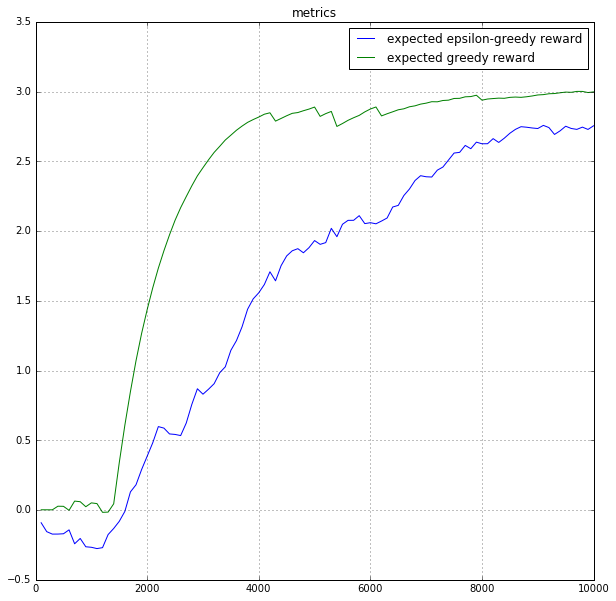

Random session examples
session # 0
 X1(qv = 2.96098303795) -> -0.10000000149 |  Y2(qv = 3.03795599937) -> 3.0 | 



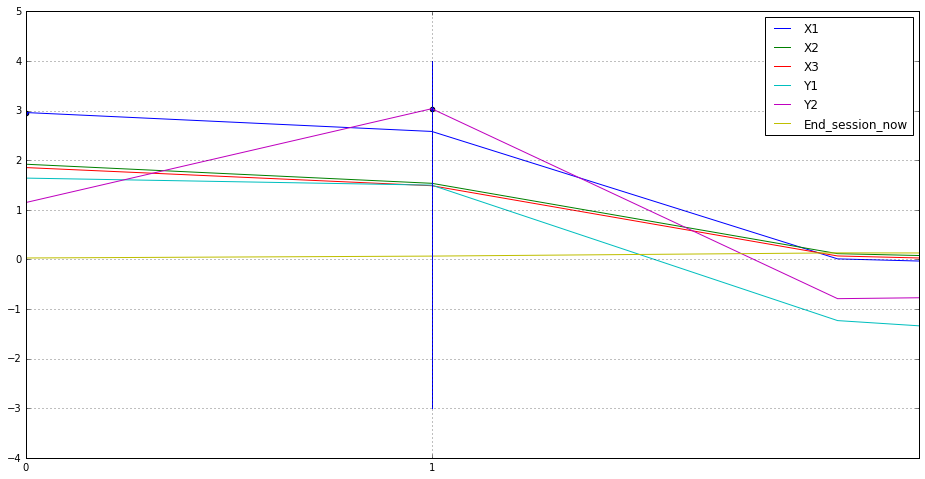

session # 1
 X1(qv = 2.96098303795) -> 0.10000000149 |  Y1(qv = 3.00026416779) -> 3.0 | 



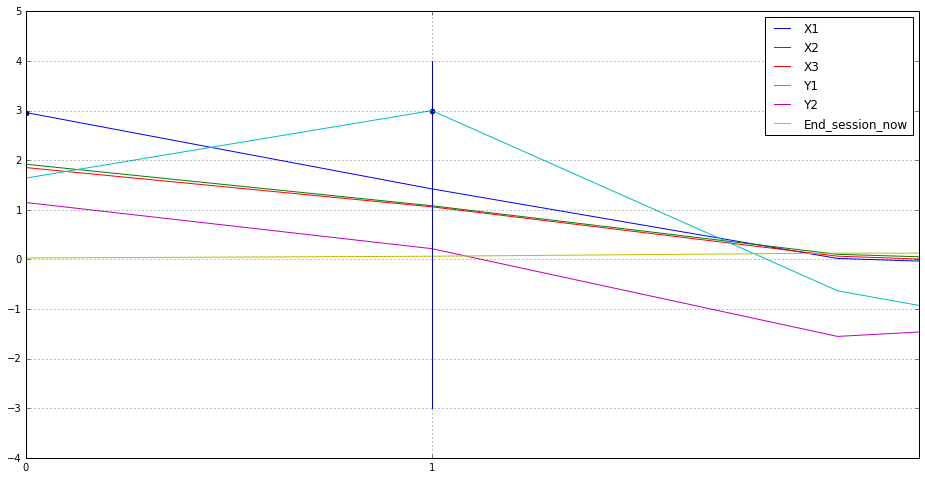

session # 2
 X1(qv = 2.96098303795) -> 0.10000000149 |  Y1(qv = 3.00026416779) -> 3.0 | 



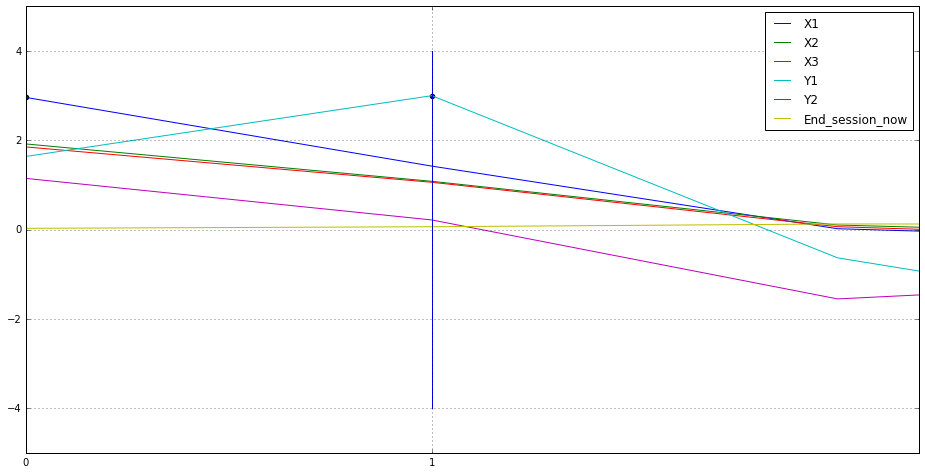

In [19]:
n_epochs = 10000
batch_size=10

for i in range(n_epochs):    
    
    #train
    env.generate_new_data_batch(batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/2500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##show current learning progress
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected epsilon-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

        
    #visualize learning curve and sample sessions
    if epoch_counter %2000 ==0:
        print "Learning curves:"
        score_log.plot()
        
        print "Random session examples"
        env.generate_new_data_batch(3)
        display_sessions(with_plots=True)



        
        
    epoch_counter  +=1


# Evaluate results

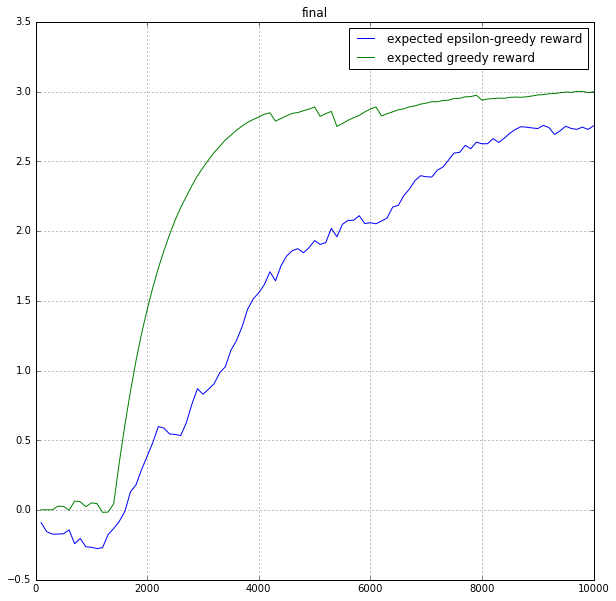

In [20]:
score_log.plot("final")

Random session examples
session # 0
 X1(qv = 2.96098351479) -> 0.10000000149 |  Y1(qv = 3.00026369095) -> 3.0 | 



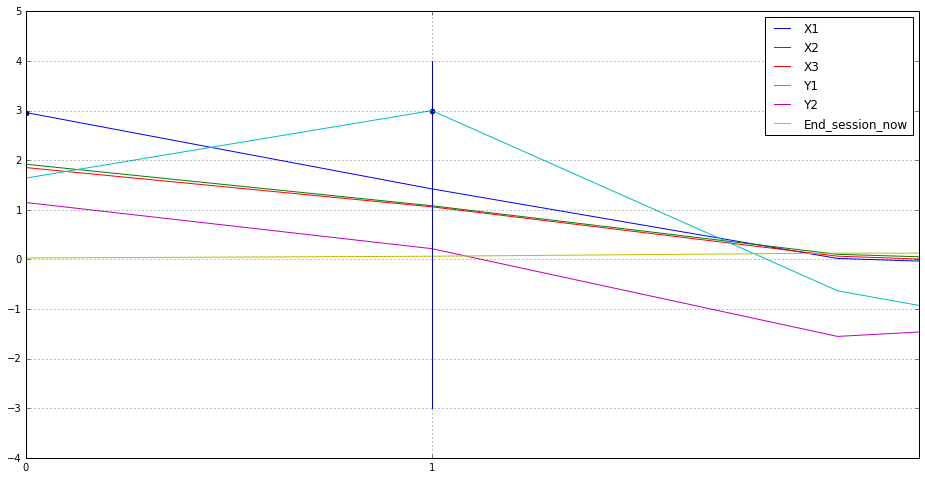

session # 1
 X1(qv = 2.96098351479) -> -0.10000000149 |  Y2(qv = 3.03795599937) -> 3.0 | 



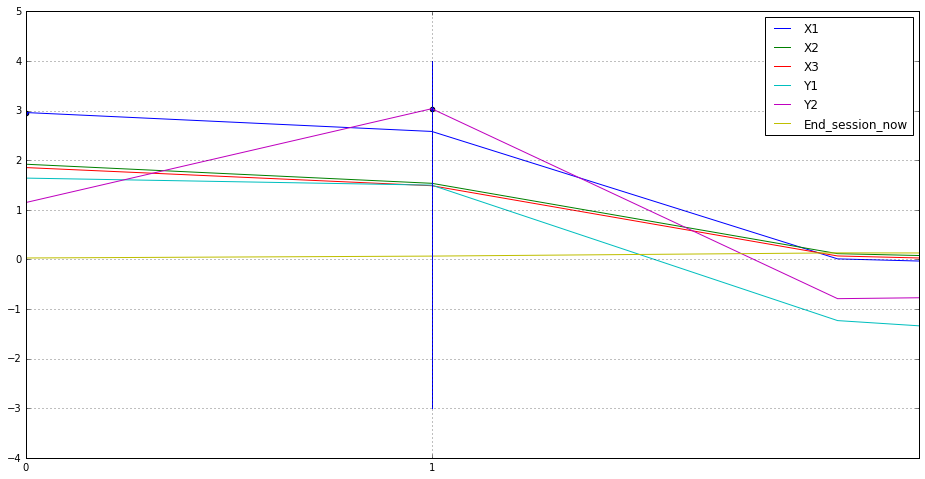

session # 2
 X1(qv = 2.96098351479) -> -0.10000000149 |  Y2(qv = 3.03795599937) -> 3.0 | 



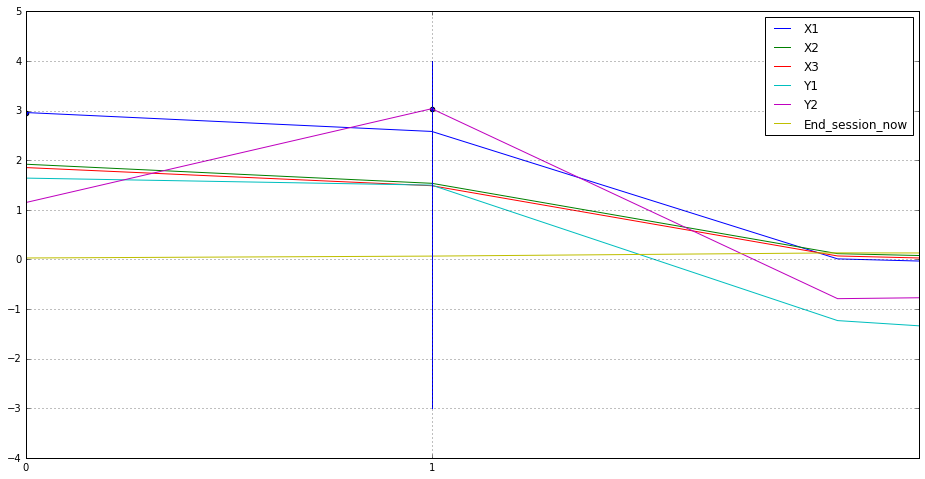

session # 3
 X1(qv = 2.96098351479) -> -0.10000000149 |  Y2(qv = 3.03795599937) -> 3.0 | 



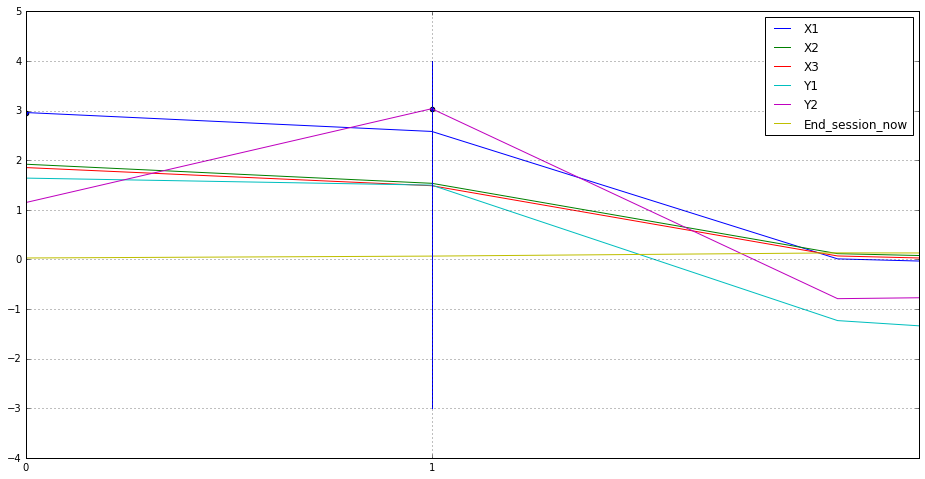

session # 4
 X1(qv = 2.96098351479) -> -0.10000000149 |  Y2(qv = 3.03795599937) -> 3.0 | 



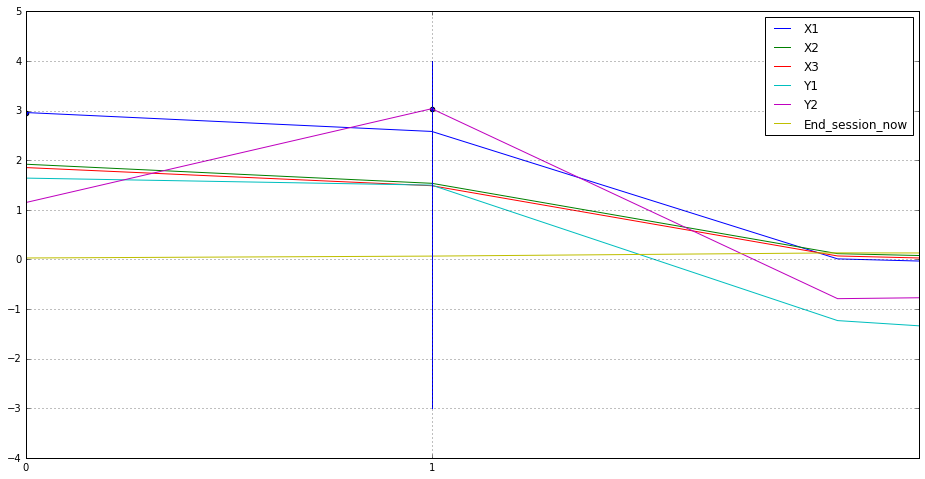

session # 5
 X1(qv = 2.96098351479) -> 0.10000000149 |  Y1(qv = 3.00026369095) -> 3.0 | 



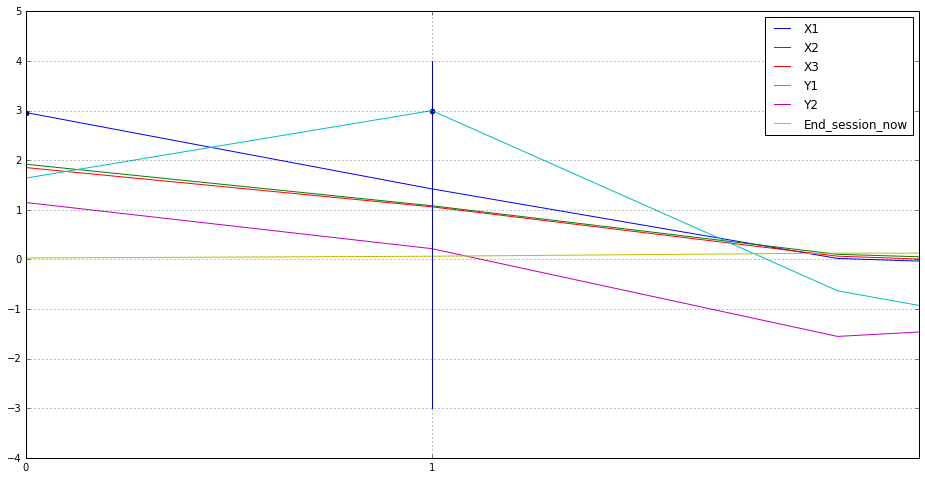

session # 6
 X1(qv = 2.96098351479) -> -0.10000000149 |  Y2(qv = 3.03795599937) -> 3.0 | 



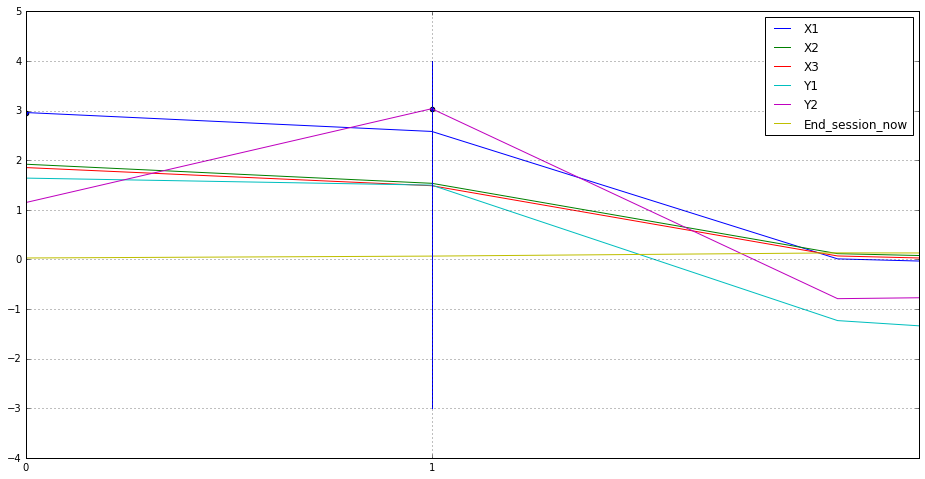

session # 7
 X1(qv = 2.96098351479) -> -0.10000000149 |  Y2(qv = 3.03795599937) -> 3.0 | 



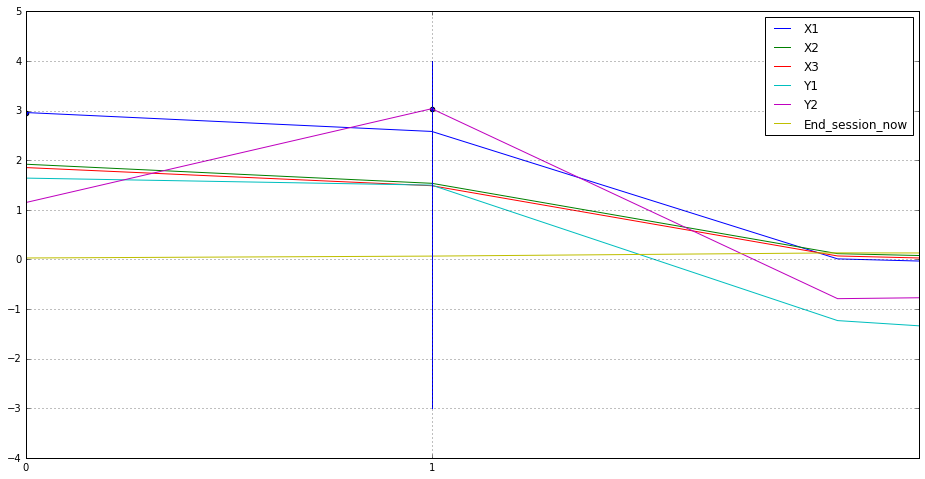

session # 8
 X1(qv = 2.96098303795) -> -0.10000000149 |  Y2(qv = 3.03795599937) -> 3.0 | 



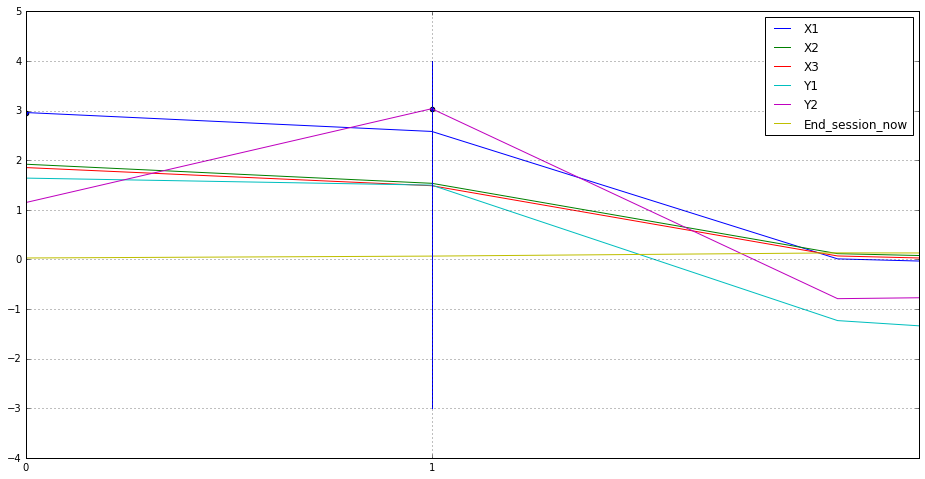

session # 9
 X1(qv = 2.96098303795) -> 0.10000000149 |  Y1(qv = 3.00026416779) -> 3.0 | 



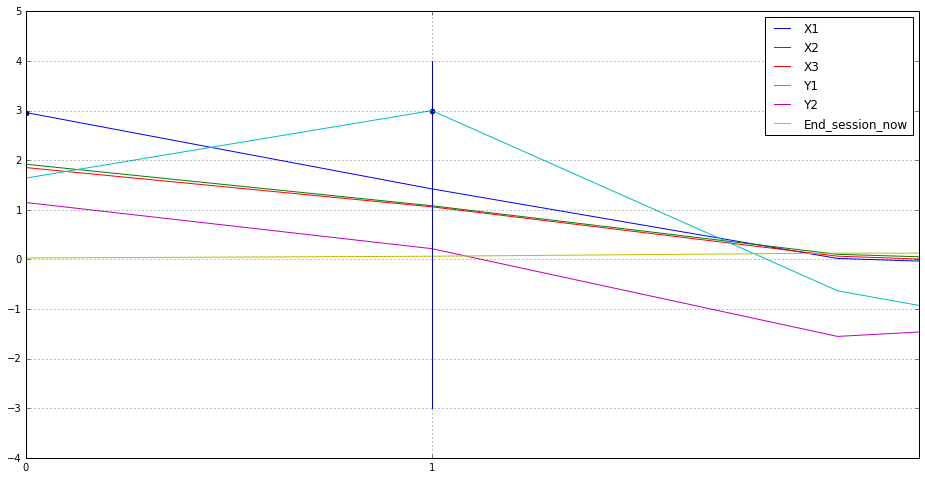

In [21]:
resolver.epsilon.set_value(np.float32(0.))
print "Random session examples"
env.generate_new_data_batch(10)
display_sessions(with_plots=True)
